# Proyek Capstone : Modelling Fruch 🍇

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from tqdm import tqdm

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import glob

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter
from collections import Counter

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Model, layers, Input, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

!pip install tensorflowjs
import tensorflowjs as tfjs

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


In [ ]:
# !pip freeze > requirements.txt

## Data Preparation

### Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
import os

path_to_downloaded_file = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")
print("Path ke file yang diunduh:", path_to_downloaded_file)

# Anda bisa menggunakan os.listdir() untuk melihat isinya.
print("Isi direktori setelah download:", os.listdir(path_to_downloaded_file))

Path ke file yang diunduh: /kaggle/input/fresh-and-stale-classification
Isi direktori setelah download: ['dataset']


#### Menggabungkan data Train, Test, dan Validation ke direktori yang sama

In [ ]:
# Direktori dan Target Kelas
base_dir = Path("/kaggle/input/fresh-and-stale-classification/dataset")
combined_dir = Path("/content/combined_dataset")
output_base = Path("/content/filtered_dataset")

target_classes = [
    "freshapples", "rottenapples",
    "freshbanana", "rottenbanana",
    "freshoranges", "rottenoranges",
    "freshtomato", "rottentomato"
]

rename_map = {
    "freshtamto": "freshtomato",
    "rottentamto": "rottentomato"
}

shutil.rmtree(combined_dir, ignore_errors=True)
shutil.rmtree(output_base, ignore_errors=True)
combined_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
# Cek Jumlah Awal File
def total_file_kelas(dataset_dir):
    total = {}
    for folder in ["Train", "Test"]:
        base = Path(dataset_dir) / folder
        for cls in os.listdir(base):
            cls_path = base / cls
            if cls_path.is_dir():
                nama = rename_map.get(cls, cls)
                total[nama] = total.get(nama, 0) + len(os.listdir(cls_path))
    return dict(sorted(total.items()))

print("Jumlah total file dari Train + Test (setelah rename):")
print(total_file_kelas(base_dir))


Jumlah total file dari Train + Test (setelah rename):
{'freshapples': 3215, 'freshbanana': 3360, 'freshbittergroud': 327, 'freshcapsicum': 990, 'freshcucumber': 775, 'freshokra': 1005, 'freshoranges': 1854, 'freshpatato': 270, 'freshpotato': 536, 'freshtomato': 2113, 'rottenapples': 4236, 'rottenbanana': 3832, 'rottenbittergroud': 357, 'rottencapsicum': 901, 'rottencucumber': 676, 'rottenokra': 562, 'rottenoranges': 1998, 'rottenpatato': 370, 'rottenpotato': 802, 'rottentomato': 2178}


In [ ]:
# print_images_resolution("/content/combined_dataset")

Plot distribusi gambar

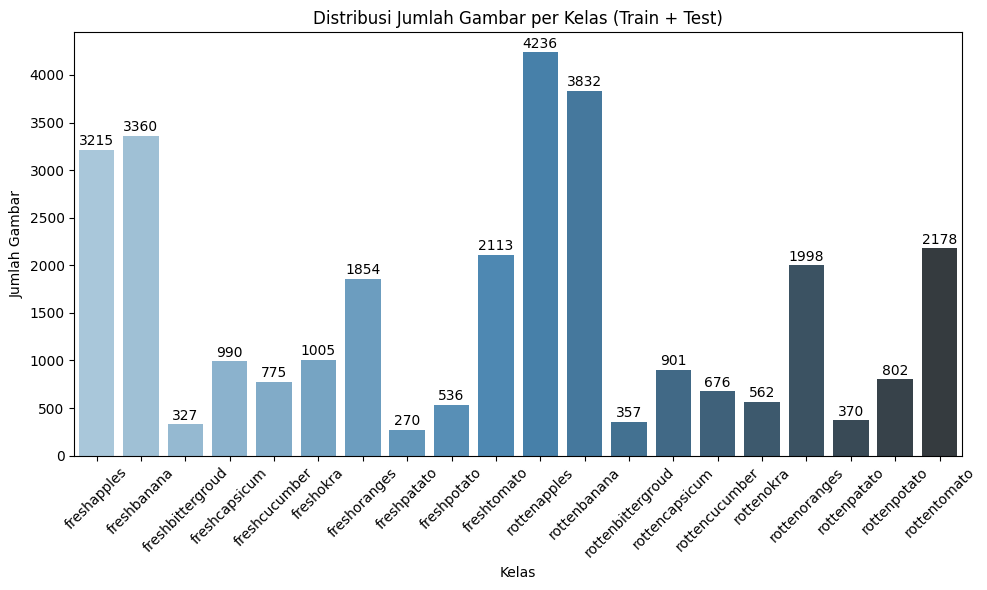

In [ ]:
# Visualisasi distribusi kelas Train + Test
jumlah_file = total_file_kelas(base_dir)

# Konversi ke DataFrame
df_jumlah_file = pd.DataFrame(list(jumlah_file.items()), columns=["labels", "jumlah"])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_jumlah_file, x="labels", y="jumlah", palette="Blues_d")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height + 50), ha='center')

plt.title("Distribusi Jumlah Gambar per Kelas (Train + Test)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Untuk _project_ ini akan digunakan jenis buah apel(_apples_), banana(_banana_), oranges(_oranges_), dan tomato(_tomato_) dan akan dilakukan _balancing_/penyeimbangan dataset karena jumlah data yang memiliki selisih cukup besar.

Merge test dan train dari dataset

In [ ]:
# Menggabungkan ke combined_dir
for folder in ["Train", "Test"]:
    folder_path = base_dir / folder
    for cls in os.listdir(folder_path):
        mapped_cls = rename_map.get(cls, cls)
        if mapped_cls in target_classes:
            src_dir = folder_path / cls
            dst_dir = combined_dir / mapped_cls
            dst_dir.mkdir(parents=True, exist_ok=True)
            for file in os.listdir(src_dir):
                shutil.copy(src_dir / file, dst_dir)

In [ ]:
# === Menggabungkan ke combined_dir ===
for folder in ["Train", "Test"]:
    folder_path = base_dir / folder
    for cls in os.listdir(folder_path):
        mapped_cls = rename_map.get(cls, cls)
        if mapped_cls in target_classes:
            src_dir = folder_path / cls
            dst_dir = combined_dir / mapped_cls
            dst_dir.mkdir(parents=True, exist_ok=True)
            for file in os.listdir(src_dir):
                shutil.copy(src_dir / file, dst_dir)

# Potong ke 1800 per kelas
output_dir = Path("/content/filtered_dataset")
output_dir.mkdir(parents=True, exist_ok=True)

target_count = 1800

for class_name in os.listdir(combined_dir):
    class_path = combined_dir / class_name
    if not class_path.is_dir():
        continue

    images = os.listdir(class_path)
    selected_images = random.sample(images, min(target_count, len(images)))
    target_class_dir = output_dir / class_name
    target_class_dir.mkdir(parents=True, exist_ok=True)

    for img in tqdm(selected_images, desc=f"Copying {class_name}"):
        src = class_path / img
        dst = target_class_dir / img
        shutil.copy(src, dst)

print("Dataset berhasil dipotong ke maksimal 1800 gambar per kelas.")

Copying freshbanana: 100%|██████████| 1800/1800 [00:00<00:00, 1818.74it/s]

Dataset berhasil dipotong ke maksimal 1800 gambar per kelas.


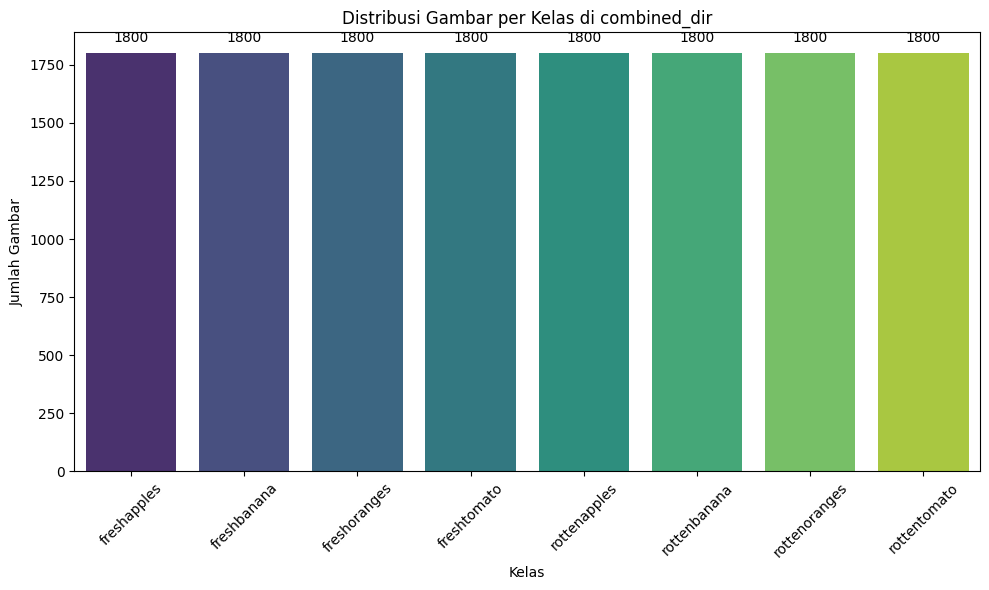

In [ ]:
# Hitung jumlah file di combined_dir
def total_file_combined(dataset_dir):
    total = {}
    for cls in os.listdir(dataset_dir):
        cls_path = dataset_dir / cls
        if cls_path.is_dir():
            total[cls] = len(os.listdir(cls_path))
    return dict(sorted(total.items()))

# Ambil data
jumlah_combined = total_file_combined(output_dir)

# Konversi ke DataFrame
df_combined = pd.DataFrame(list(jumlah_combined.items()), columns=["labels", "jumlah"])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_combined, x="labels", y="jumlah", palette="viridis")

# Tambahkan angka di atas bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2, height + 50), ha='center')

plt.title("Distribusi Gambar per Kelas di combined_dir")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Hitung dari Train dan Test
len(os.listdir(base_dir / "Train" / "freshapples")) + len(os.listdir(base_dir / "Test" / "freshapples"))


3215

In [ ]:
# Hitung di combined_dir
len(os.listdir(combined_dir / "freshapples"))

2819

Terdapat pengurangan jumlah data antara sebelum merge dan setelah, ini kemungkinan diakibatkan oleh nama file gambar di dataset yang sama/tumpang tindih. Sehingga, hanya di-_keep_ salah satu gambar saja

### Data Preprocessing

#### Split Dataset

In [ ]:
# Ambil path, file name, dan label dari dataset yang sudah digabung
mypath = '/content/combined_dataset'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({'path': full_path, 'file_name': file_name, 'labels': labels})

# Filter df untuk hanya menyertakan gambar yang sudah dipilih (di filtered_dataset)
filtered_dir = Path("/content/filtered_dataset")
filtered_set = set()
for path, _, files in os.walk(filtered_dir):
    for name in files:
        filtered_set.add(name)

df = df[df['file_name'].isin(filtered_set)].reset_index(drop=True)

In [ ]:
# Split 70% train, 30% temp (val + test)
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)

# Split temp menjadi 20% val dan 10% test (2:1 ratio artinya val = 2/3, test = 1/3 dari 30%)
df_val, df_test = train_test_split(df_temp, test_size=1/3, stratify=df_temp['labels'], random_state=42)

# Cek distribusi hasil split
print("\nDistribusi setelah split:")
print("Train:\n", df_train['labels'].value_counts())
print("Val:\n", df_val['labels'].value_counts())
print("Test:\n", df_test['labels'].value_counts())

# Fungsi untuk copy hasil split ke folder
def copy_split_to_folders(df_split, split_name, base_output_dir):
    for _, row in df_split.iterrows():
        label_dir = base_output_dir / split_name / row['labels']
        label_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(row['path'], label_dir)

# Set direktori output
output_base = Path("/content/filtered_dataset")

# Hapus dulu jika sebelumnya sudah ada
shutil.rmtree(output_base, ignore_errors=True)

# Salin ke folder train/val/test
copy_split_to_folders(df_train, "train", output_base)
copy_split_to_folders(df_val, "val", output_base)
copy_split_to_folders(df_test, "test", output_base)

print("\n Dataset berhasil di-split dan disalin ke /content/filtered_dataset")


Distribusi setelah split:
Train:
 labels
freshapples      1260
freshoranges     1260
rottenoranges    1260
freshtomato      1260
freshbanana      1260
rottenbanana     1260
rottentomato     1260
rottenapples     1260
Name: count, dtype: int64
Val:
 labels
rottenapples     360
rottenoranges    360
freshbanana      360
freshapples      360
freshoranges     360
rottenbanana     360
rottentomato     360
freshtomato      360
Name: count, dtype: int64
Test:
 labels
freshbanana      180
rottenoranges    180
freshoranges     180
freshapples      180
rottenapples     180
rottentomato     180
rottenbanana     180
freshtomato      180
Name: count, dtype: int64

 Dataset berhasil di-split dan disalin ke /content/filtered_dataset


In [ ]:
# Tambahkan kolom 'set' agar bisa dicek setelah split
df_train['set'] = 'train'
df_val['set'] = 'val'
df_test['set'] = 'test'

# Gabungkan semua ke satu DataFrame
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Cek distribusi total
print('\n==================== FINAL SPLIT RESULT ====================\n')
print(df_all.groupby(['set', 'labels']).size())
print('\n============================================================\n')

# Cek sample data
print(df_all.sample(5))



==================== FINAL SPLIT RESULT ====================

set    labels       
test   freshapples       180
       freshbanana       180
       freshoranges      180
       freshtomato       180
       rottenapples      180
       rottenbanana      180
       rottenoranges     180
       rottentomato      180
train  freshapples      1260
       freshbanana      1260
       freshoranges     1260
       freshtomato      1260
       rottenapples     1260
       rottenbanana     1260
       rottenoranges    1260
       rottentomato     1260
val    freshapples       360
       freshbanana       360
       freshoranges      360
       freshtomato       360
       rottenapples      360
       rottenbanana      360
       rottenoranges     360
       rottentomato      360
dtype: int64


                                                    path  \
13447  /content/combined_dataset/rottenoranges/rotate...   
13965  /content/combined_dataset/rottenbanana/rotated...   
11777   /content/combined

#### Augmentasi

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# Val & Test: tanpa augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk val
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk test
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 10080 validated image filenames belonging to 8 classes.
Found 2880 validated image filenames belonging to 8 classes.
Found 1440 validated image filenames belonging to 8 classes.


In [ ]:
# Mapping indeks ke nama kelas
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Training
print("Distribusi kelas pada data training:")
train_counts = Counter(train_generator.classes)
for index, count in sorted(train_counts.items()):
    print(f"{index_to_class[index]}: {count}")

# Validation
print("\nDistribusi kelas pada data validasi:")
val_counts = Counter(val_generator.classes)
for index, count in sorted(val_counts.items()):
    print(f"{index_to_class[index]}: {count}")

# Test
print("\nDistribusi kelas pada data test:")
test_counts = Counter(test_generator.classes)
for index, count in sorted(test_counts.items()):
    print(f"{index_to_class[index]}: {count}")

Distribusi kelas pada data training:
freshapples: 1260
freshbanana: 1260
freshoranges: 1260
freshtomato: 1260
rottenapples: 1260
rottenbanana: 1260
rottenoranges: 1260
rottentomato: 1260

Distribusi kelas pada data validasi:
freshapples: 360
freshbanana: 360
freshoranges: 360
freshtomato: 360
rottenapples: 360
rottenbanana: 360
rottenoranges: 360
rottentomato: 360

Distribusi kelas pada data test:
freshapples: 180
freshbanana: 180
freshoranges: 180
freshtomato: 180
rottenapples: 180
rottenbanana: 180
rottenoranges: 180
rottentomato: 180


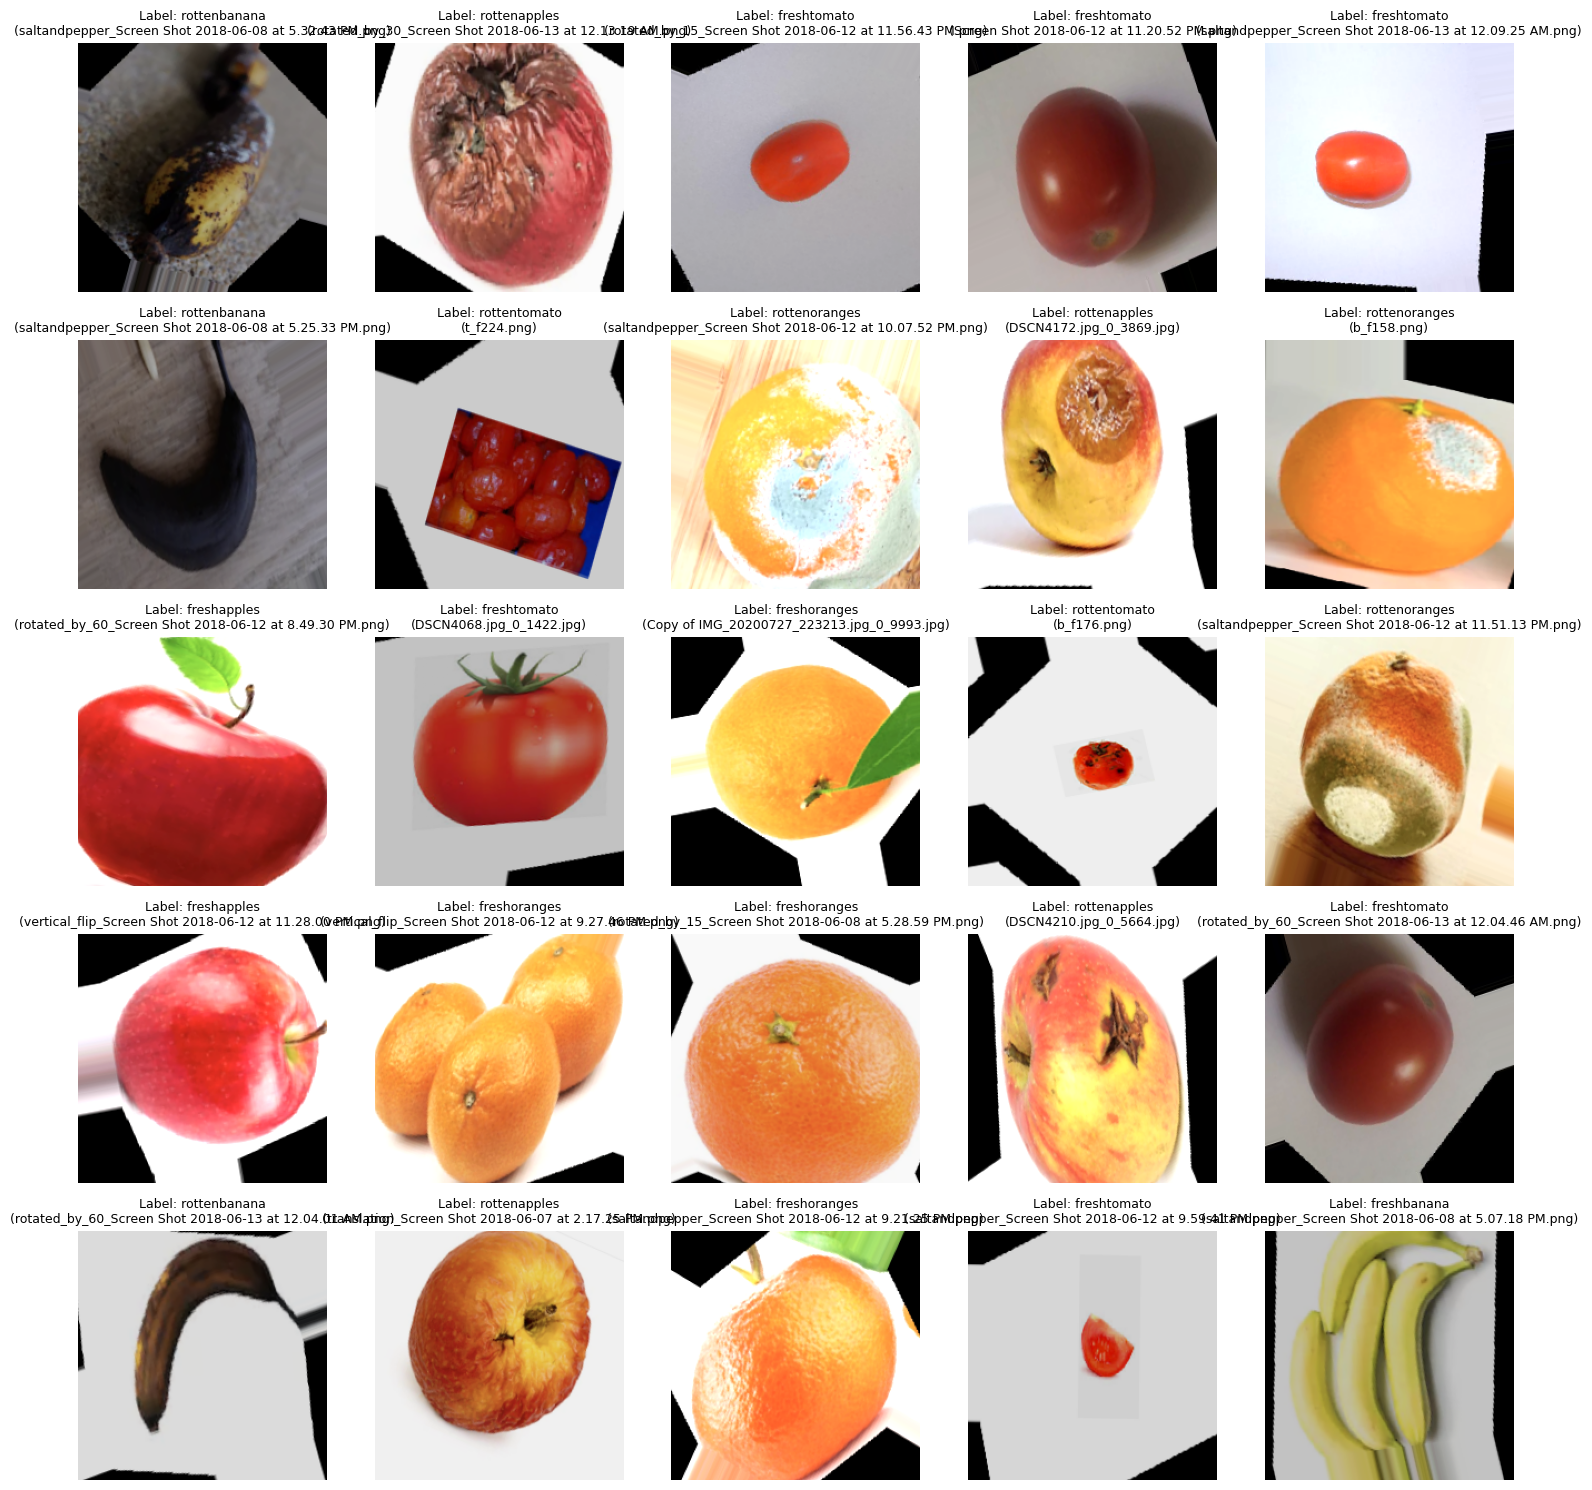

In [ ]:
def show_augmentations(generator, num_samples=25):
    images, labels = next(generator)

    class_indices = {v: k for k, v in generator.class_indices.items()}
    true_classes = labels.argmax(axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(min(num_samples, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        filename = os.path.basename(generator.filepaths[i])
        label_name = class_indices[true_classes[i]]
        plt.title(f"Label: {label_name}\n({filename})", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Jalankan untuk tampilkan gambar dengan augmentasi dan labelnya
show_augmentations(train_generator)


## Modelling

In [ ]:
# # Model Menggunakan Model Sequential, Conv2D, Pooling Layer
# # Menggunakan MobileNet yang merupaakan jenis arsitektur CNN yang dioptimalkan untuk efisiensi.
# # Load base model MobileNetV2 tanpa top layer
# ==== Load base model tanpa top ====
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

# Fine-tune dari layer ke-60 ke bawah
fine_tune_at = 60
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# ==== Bangun Model Sequential ====
model = Sequential([
    base_model,

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(8, activation='softmax')  # Jumlah kelas
])

# ==== Compile Model ====
model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Tampilkan ringkasan model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,703,368 (21.76 MB)

 Trainable params: 5,604,360 (21.38 MB)

 Non-trainable params: 99,008 (386.75 KB)

In [ ]:
print("Total training images:", train_generator.samples)
print("Total validation images:", val_generator.samples)
print("Total test images:", test_generator.samples)

Total training images: 10080
Total validation images: 2880
Total test images: 1440


In [ ]:
# Callback EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 219s 570ms/step - accuracy: 0.2841 - loss: 7.2813 - val_accuracy: 0.6979 - val_loss: 5.9110 - learning_rate: 3.0000e-05
Epoch 2/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 175s 556ms/step - accuracy: 0.8117 - loss: 5.5958 - val_accuracy: 0.8080 - val_loss: 5.1987 - learning_rate: 3.0000e-05
Epoch 3/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 178s 566ms/step - accuracy: 0.9201 - loss: 4.8688 - val_accuracy: 0.9424 - val_loss: 4.4587 - learning_rate: 3.0000e-05
Epoch 4/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 175s 557ms/step - accuracy: 0.9534 - loss: 4.3638 - val_accuracy: 0.9719 - val_loss: 3.9899 - learning_rate: 3.0000e-05
Epoch 5/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 177s 562ms/step - accuracy: 0.9691 - loss: 3.9318 - val_accuracy: 0.9875 - val_loss: 3.5621 - learning_rate: 3.0000e-05
Epoch 6/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 176s 558ms/step - accuracy: 0.9743 - loss: 3.5329 - val_accuracy: 0.9965 - val_loss: 3.1791 - learning_rate: 3.0000e-05
Epoch 7/80
315/315 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluasi performa
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9998 - loss: 0.7060
Test Accuracy: 0.9986


Karena hasil training sudah bagus, maka tidak perlu dilakukan tuning lebih lanjut.

## Evaluasi dan Visualisasi

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
Classification Report:
               precision    recall  f1-score   support

  freshapples       1.00      1.00      1.00       180
  freshbanana       1.00      1.00      1.00       180
 freshoranges       0.99      1.00      0.99       180
  freshtomato       1.00      1.00      1.00       180
 rottenapples       1.00      1.00      1.00       180
 rottenbanana       1.00      1.00      1.00       180
rottenoranges       1.00      0.99      0.99       180
 rottentomato       1.00      1.00      1.00       180

     accuracy                           1.00      1440
    macro avg       1.00      1.00      1.00      1440
 weighted avg       1.00      1.00      1.00      1440



<Figure size 1000x800 with 0 Axes>

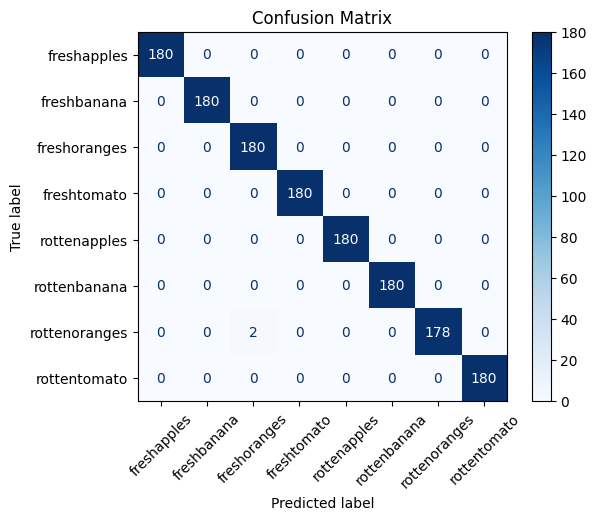

In [ ]:
# Prediksi label test
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True label
y_true = test_generator.classes

# Label nama kelas
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Found 32 validated image filenames belonging to 8 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


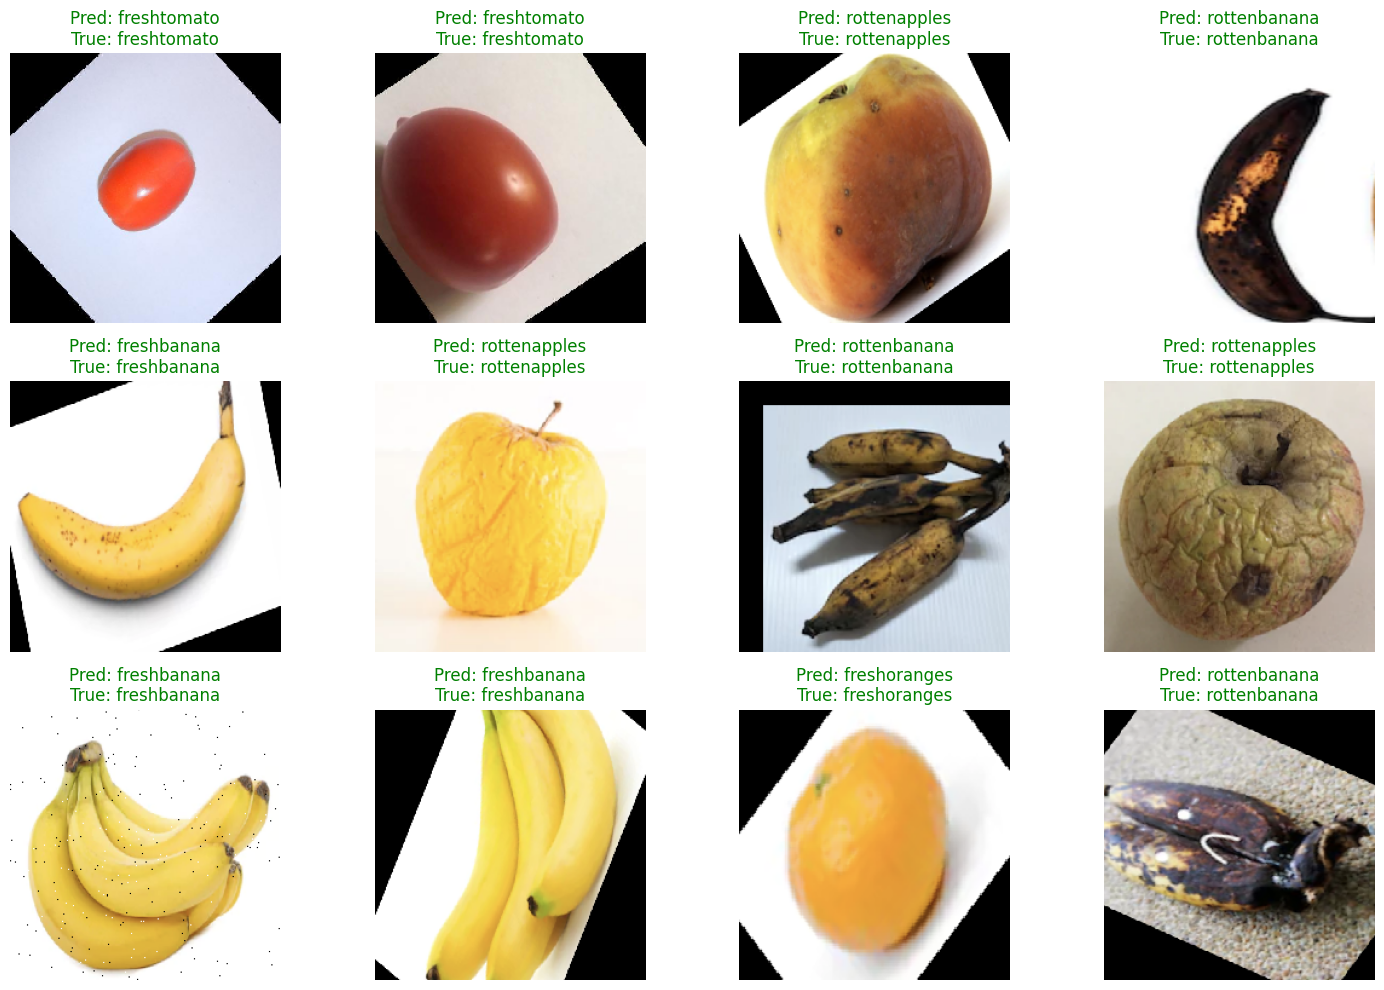

In [ ]:
# Ambil 32 gambar pertama
x_test, y_test = next(test_datagen.flow_from_dataframe(
    dataframe=df_test.sample(32, random_state=42),  # sampling acak
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
))

preds = model.predict(x_test)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_test, axis=1)

plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    pred_label = class_labels[pred_classes[i]]
    true_label = class_labels[true_classes[i]]
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()


## Konversi Model

In [ ]:
# 1. Simpan model
model.save('/content/drive/MyDrive/fruit_model.h5')
model.export('/content/drive/MyDrive/saved_model')

# 2. Konversi ke TensorFlow.js dari file .h5
!tensorflowjs_converter \
  --input_format keras \
  /content/drive/MyDrive/fruit_model.h5 \
  /content/drive/MyDrive/tfjs_model/

# 3. Konversi ke TFLite dari SavedModel

converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/saved_model')
tflite_model = converter.convert()

with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
    f.write(tflite_model)


## Inference (Optional)

In [ ]:
print(test_generator.class_indices)

class_indices = test_generator.class_indices  # atau train_generator.class_indices
for label, index in class_indices.items():
    print(f"{index}: {label}")

{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'freshtomato': 3, 'rottenapples': 4, 'rottenbanana': 5, 'rottenoranges': 6, 'rottentomato': 7}
0: freshapples
1: freshbanana
2: freshoranges
3: freshtomato
4: rottenapples
5: rottenbanana
6: rottenoranges
7: rottentomato


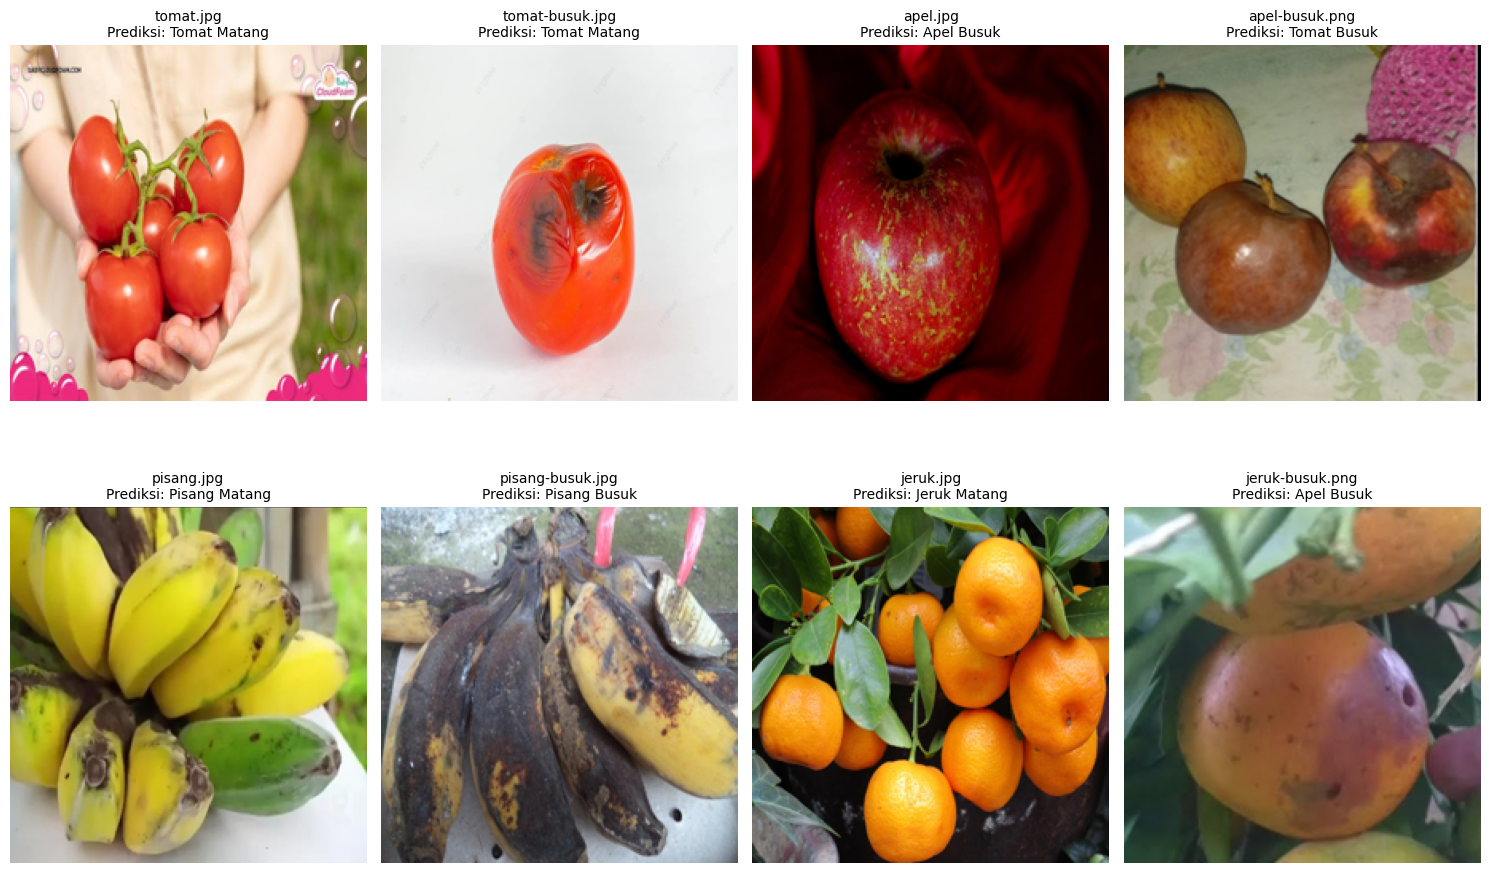

In [ ]:
# Load SavedModel
model_path = '/content/drive/MyDrive/saved_model'
loaded_model = tf.saved_model.load(model_path)
infer = loaded_model.signatures["serving_default"]

# Daftar path gambar
image_paths = [
    '/content/drive/MyDrive/tomat.jpg',
    '/content/drive/MyDrive/tomat-busuk.jpg',
    '/content/drive/MyDrive/apel.jpg',
    '/content/drive/MyDrive/apel-busuk.png',
    '/content/drive/MyDrive/pisang.jpg',
    '/content/drive/MyDrive/pisang-busuk.jpg',
    '/content/drive/MyDrive/jeruk.jpg',
    '/content/drive/MyDrive/jeruk-busuk.png'
]

# Label kelas (urutan sesuai pelatihan model)
class_labels = {
    0: 'Apel Matang',
    1: 'Pisang Matang',
    2: 'Jeruk Matang',
    3: 'Tomat Matang',
    4: 'Apel Busuk',
    5: 'Pisang Busuk',
    6: 'Jeruk Busuk',
    7: 'Tomat Busuk'
}

# Fungsi untuk prediksi dan visualisasi
def predict_and_display(image_paths):
    plt.figure(figsize=(15, 10))

    for i, path in enumerate(image_paths):
        try:
            # Load dan preprocess
            img = Image.open(path).convert('RGB').resize((224, 224))
            img_array = np.array(img, dtype=np.float32) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            input_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

            # Inference
            predictions = infer(input_tensor)
            output_key = list(predictions.keys())[0]
            prediction = predictions[output_key].numpy()
            pred_class = np.argmax(prediction)
            pred_label = class_labels.get(pred_class, "Tidak Diketahui")

            # Plot
            plt.subplot(2, 4, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{os.path.basename(path)}\nPrediksi: {pred_label}", fontsize=10)
        except Exception as e:
            print(f"Gagal memproses {path}: {e}")

    plt.tight_layout()
    plt.show()

# Jalankan
predict_and_display(image_paths)

In [ ]:
# with open("label.txt", "w") as f:
#     f.write("\n".join(train_generator.class_indices.keys()))